In [2]:
from argparse import Namespace
from numpy.core.arrayprint import _leading_trailing
from numpy.core.fromnumeric import shape

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


2021-09-24 15:20:35.153231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-24 15:20:35.153277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [37]:
args = Namespace(
    dataset_csv = 'data/olist_order_reviews_dataset.csv',
    train_split = 0.8,
    random_state = 42,
    vocab_size = 10000,
    embedding_dim = 16,
    max_length = 120,
    batch_size=128,
    num_epochs=5,
    early_stopping_criteria=2,
    dropout_p=0.3,
    model_storage="model_storage/lstm",)

In [38]:
def load_data(path, column_text='review_comment_message', column_score='review_score', points_cut = [0,2,5], classes = [0, 1]):
    df = pd.read_csv(path)

    df = df.dropna(subset=[column_text])

    df['label'] = pd.cut(df[column_score], bins=points_cut, labels=classes)

    df = df.rename(columns={column_text: 'text'})
    df = df[['text', 'label']]

    return df

In [39]:
df = load_data(args.dataset_csv)

In [6]:
def split_train_test(data, split_train=0.8, random_state=200):
    """
    Args
        df - Dataframe 
        split_train - Percent of subset train 
        random_state - Random State 
    Return
        training_sentence - training subset with text
        training_label - training subset with label
        test_sentence - test subset with text
        test_label - test subset with label
    """

    df_train  = data.sample(frac = split_train, random_state=random_state)
    df_test = data.drop(df_train.index)

    training_sentences = []
    training_labels = []
    testing_sentences = []
    testing_labels = []

    for index, train in df_train.iterrows():
        training_sentences.append(str(train['text']))
        training_labels.append(train['label'])
    
    for index, test in df_test.iterrows():
        testing_sentences.append(str(test['text']))
        testing_labels.append(test['label'])
    
    training_labels_final = np.array(training_labels)
    testing_labels_final = np.array(testing_labels)

    return training_sentences, training_labels, testing_sentences, testing_labels


In [7]:
training_sentences, training_labels, testing_sentences, testing_labels = split_train_test(df, split_train=args.train_split, random_state=args.random_state)


No código abaixo utilizaremos a classe Tokenizer para criar um vocabulário interno 
e depois chamaremos o método texts_to_sequencestransformar as sentenças em sequências. 
Logo em seguida, fixaremos o tamanho das sequências preenchendo com zero, utilizando 
o método pad_sequences.


In [8]:
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=args.vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [9]:
def preprocess(training_sentences, testing_sentences, max_length, vocab_size, trunc_type='post', oov_tok='<OOV>'):
    """
    Args
        training_sentences
        training_labels
        testing_sentences
        testing_labels
    Return
        training_sentences
        training_labels
        testing_sentences
        testing_labels 
    """

    training_sentences = tokenizer.texts_to_sequences(training_sentences)
    training_padded = pad_sequences(training_sentences, maxlen=max_length, truncating=trunc_type)

    testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
    testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

    return training_padded, testing_padded

In [10]:
training_sentences, testing_sentences = preprocess(training_sentences, testing_sentences, args.max_length, args.vocab_size)

Projetaremos nossa rede neural com uma camada de tf.keras.layers.Embedding para que vetorizar 
as sequências. Seguido de camadas de tf.keras.layers.LSTM. E utilizaremos tf.keras.layers.Dropout 
para controlar o overfitting da nossa rede.


In [11]:
def create_model():
    input = tf.keras.Input(shape=(args.max_length))
    x = tf.keras.layers.Embedding(args.vocab_size, args.embedding_dim, input_length=args.max_length)(input)

    x = tf.keras.layers.LSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(16)(x)

    x = tf.keras.layers.Dropout(0.6)(x)

    x = tf.keras.layers.Dense(32, activation='relu')(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(input, output)

In [13]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=args.early_stopping_criteria)

model = create_model()
model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.0001),
  metrics=['accuracy']
)

history = model.fit(
    x=training_sentences,
    y=np.array(training_labels),
    validation_data=(testing_sentences, np.array(testing_labels)),
    epochs=15,
    batch_size=args.batch_size,
    callbacks= [earlyStoppingCallback],
)


Epoch 1/15
261/261 [==============================] - 49s 169ms/step - loss: 0.6085 - accuracy: 0.7199 - val_loss: 0.5330 - val_accuracy: 0.7219
Epoch 2/15
261/261 [==============================] - 32s 121ms/step - loss: 0.5114 - accuracy: 0.7449 - val_loss: 0.4763 - val_accuracy: 0.7795
Epoch 3/15
261/261 [==============================] - 31s 118ms/step - loss: 0.4536 - accuracy: 0.7969 - val_loss: 0.4088 - val_accuracy: 0.8101
Epoch 4/15
261/261 [==============================] - 31s 118ms/step - loss: 0.3789 - accuracy: 0.8326 - val_loss: 0.3497 - val_accuracy: 0.8387
Epoch 5/15
261/261 [==============================] - 31s 117ms/step - loss: 0.3320 - accuracy: 0.8577 - val_loss: 0.3234 - val_accuracy: 0.8591
Epoch 6/15
261/261 [==============================] - 32s 123ms/step - loss: 0.3072 - accuracy: 0.8721 - val_loss: 0.3107 - val_accuracy: 0.8656
Epoch 7/15
261/261 [==============================] - 31s 117ms/step - loss: 0.2913 - accuracy: 0.8808 - val_loss: 0.3017 - val_ac

# Validando modelo

In [14]:
model.evaluate(testing_sentences, np.array(testing_labels))

261/261 [==============================] - 6s 22ms/step - loss: 0.2824 - accuracy: 0.8888


[0.28240686655044556, 0.8887558579444885]

### Curva de acurácia

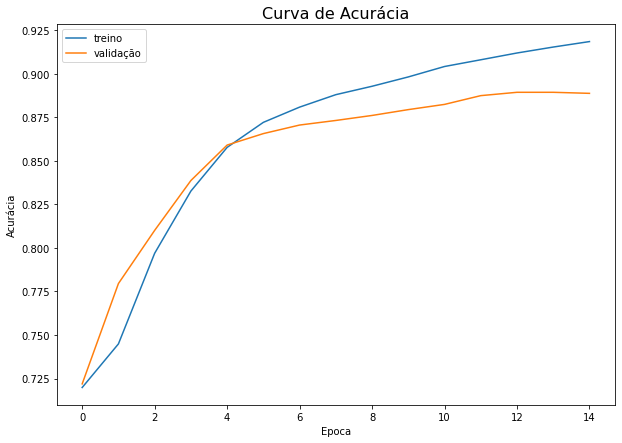

In [15]:
# Curva de acuracia
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Acurácia', fontsize = 16)
plt.ylabel('Acurácia')
plt.xlabel('Epoca')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

### Curva de perda

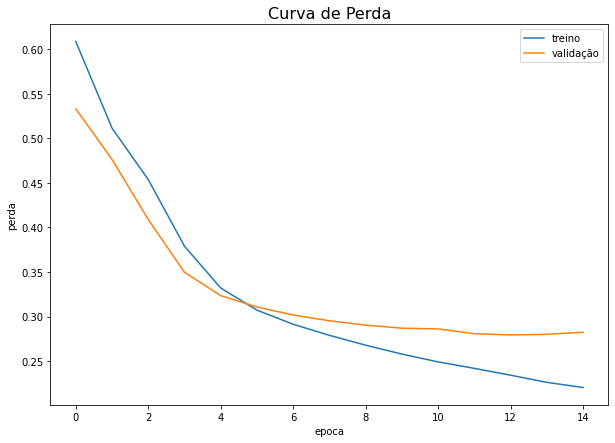

In [16]:
# Curva de perda
plt.figure(figsize = (10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Curva de Perda', fontsize = 16)
plt.ylabel('perda')
plt.xlabel('epoca')
plt.legend(['treino', 'validação'], loc='upper right')
plt.show()

In [17]:
y_predicted_prob = model.predict(testing_sentences, verbose=0)
y_predicted_classes = np.where(y_predicted_prob > 0.5, 1, 0)

y_predicted_prob = y_predicted_prob[:,0]
y_predicted_classes = y_predicted_classes[:,0]

In [18]:
accuracy = accuracy_score(testing_labels, y_predicted_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(testing_labels, y_predicted_classes)
print('Precision: %f' % precision)

f1 = f1_score(testing_labels, y_predicted_classes)
print('F1: %f' % f1)

recall = recall_score(testing_labels, y_predicted_classes)
print('Recall: %f' % recall)

Accuracy: 0.888756
Precision: 0.926993
F1: 0.922590
Recall: 0.918229


### Curva ROC

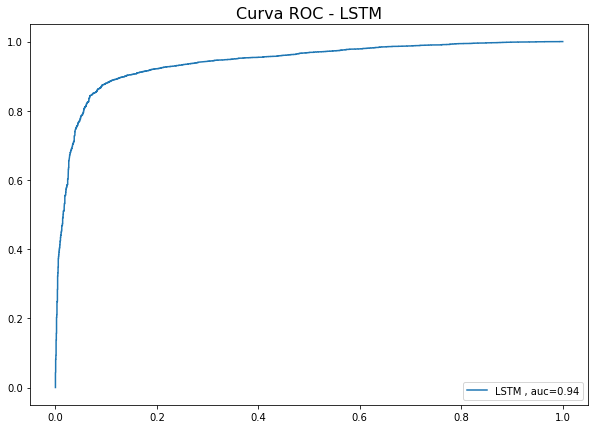

In [19]:
# ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(testing_labels, y_predicted_prob)
auc = roc_auc_score(testing_labels, y_predicted_prob)
plt.figure(figsize = (10,7))

plt.plot(fpr,tpr,label="LSTM , auc="+str(round(auc,2)))
plt.title('Curva ROC - LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()

### Matrix de Confusão

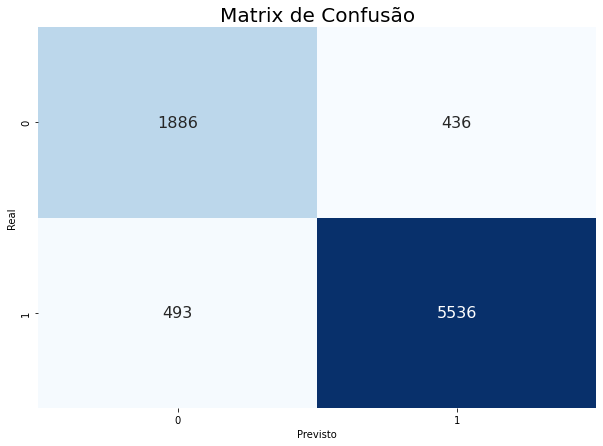

In [20]:
#matriz de confusao
data = confusion_matrix(testing_labels, y_predicted_classes)
df_cm = pd.DataFrame(data, columns=np.unique(y_predicted_classes), index = np.unique(y_predicted_classes))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Previsto'
plt.figure(figsize = (10,7))
plt.title('Matrix de Confusão', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Testando novas sentenças

In [33]:
new_sentences = [
    'Execelente produto.',
    'Recomendo',
    'Não compro nunca mais',
    'Veio com defeito',
    'demorou 4 dias além do prazo',
    'Produto chegou com defeito',
    'Muito bom, porém é menor do que as medidas mostradas',
    'tamanho veio errado mas a cor é bonita',
    'tamanho veio errado'
]

new_sequences = tokenizer.texts_to_sequences(new_sentences)
padded = pad_sequences(new_sequences, maxlen=args.max_length, truncating='post')
output = model.predict(padded)
output = np.where(output > 0.5, 'positivo', 'negativo')

for i in range(0, len(new_sequences)):
    print('Review: {0} || Sentiment: {1}'.format(new_sentences[i], output[i]))

Review: Execelente produto. || Sentiment: ['positivo']
Review: Recomendo || Sentiment: ['positivo']
Review: Não compro nunca mais || Sentiment: ['negativo']
Review: Veio com defeito || Sentiment: ['positivo']
Review: demorou 4 dias além do prazo || Sentiment: ['negativo']
Review: Produto chegou com defeito || Sentiment: ['positivo']
Review: Muito bom, porém é menor do que as medidas mostradas || Sentiment: ['positivo']
Review: tamanho veio errado mas a cor é bonita || Sentiment: ['positivo']
Review: tamanho veio errado || Sentiment: ['positivo']
